In [96]:
import glob
import numpy as np
import pandas as pd 
import xgboost as xgb


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler


# Load the feature matrix
X = pd.read_csv('data/Set_4/featurized_materials.csv')
ids = X['id']
print(ids.shape)
X = X.drop(columns=['id', 'is_centrosymmetric', "crystal_system"])
columns = X.columns.tolist()
print(X.shape)
X = X.values

T = pd.read_csv('trainingfeaturized_materials.csv')
T = T.drop(columns=['id', 'is_centrosymmetric', "crystal_system"])
T = T.values



(7343,)
(7343, 296)


In [ ]:
scaler = StandardScaler()
#T = scaler.fit_transform(T)
X = scaler.fit_transform(X)


In [98]:
'''with open("feature_names_test.csv", "r") as f:
    test_names_line = f.readline().strip()
test_names_list = [name.strip() for name in test_names_line.split(",")]
print(test_names_list)
print(columns)'''

'with open("feature_names_test.csv", "r") as f:\n    test_names_line = f.readline().strip()\ntest_names_list = [name.strip() for name in test_names_line.split(",")]\nprint(test_names_list)\nprint(columns)'

In [111]:
import glob
import numpy as np
import xgboost as xgb
import pandas as pd

# Find all model paths
model_paths = glob.glob("models/xgb*")

# Thresholds from 0.50 to 0.99 (inclusive) with step 0.01
thresholds = np.round(np.arange(0.50, 1.00, 0.01), 2)

# Store score arrays per model
model_scores = []

for path in model_paths:
    model = xgb.XGBClassifier()
    model.load_model(path)

    # Predict class 1 probabilities
    probs = model.predict_proba(X)[:, 1]

    score = np.zeros_like(probs, dtype=int)
    for threshold in thresholds:
        score += (probs >= threshold).astype(int)

    model_scores.append(score)
    print(f"{path}: Done scoring")

# Build DataFrame: rows = samples, columns = models
scores_df = pd.DataFrame(model_scores).T
scores_df.columns = [f"model_{i}_score" for i in range(len(model_scores))]

# Compute total score per sample across all models
scores_df["total_score"] = scores_df.sum(axis=1)
scores_df.insert(0, "id", ids.values)

# Save
scores_df.to_csv("threshold_scores.csv", index=False)
print("Saved threshold_scores.csv with per-model and total scores.")


models\xgb_class_f1.7.0.json: Done scoring
models\xgb_class_f1.7.1.json: Done scoring
models\xgb_class_f1.7.2.json: Done scoring
models\xgb_class_nSMOTE_f1.7.0.json: Done scoring
models\xgb_class_nSMOTE_f1.7.1.json: Done scoring
models\xgb_class_nSMOTE_f1.7.2.json: Done scoring
Saved threshold_scores.csv with per-model and total scores.


In [112]:
xgb_scores_df = pd.read_csv("threshold_scores.csv")

# Sort by total_score in descending order and take top 10
top10_xgb = xgb_scores_df.sort_values(by="total_score", ascending=False).head(10)

# Print only ID and total score
print("Top 10 Highest Scoring Materials (XGBoost):")
print(top10_xgb[["id", "total_score"]])

Top 10 Highest Scoring Materials (XGBoost):
              id  total_score
3676    mp-18913          258
2129  mp-1079364          258
1666    mp-28873          258
2177  mp-1205774          258
1657    mp-27193          258
2843   mp-725977          258
4433     mp-3481          258
5888  mp-1206815          258
1794     mp-7684          258
1716   mp-550506          258


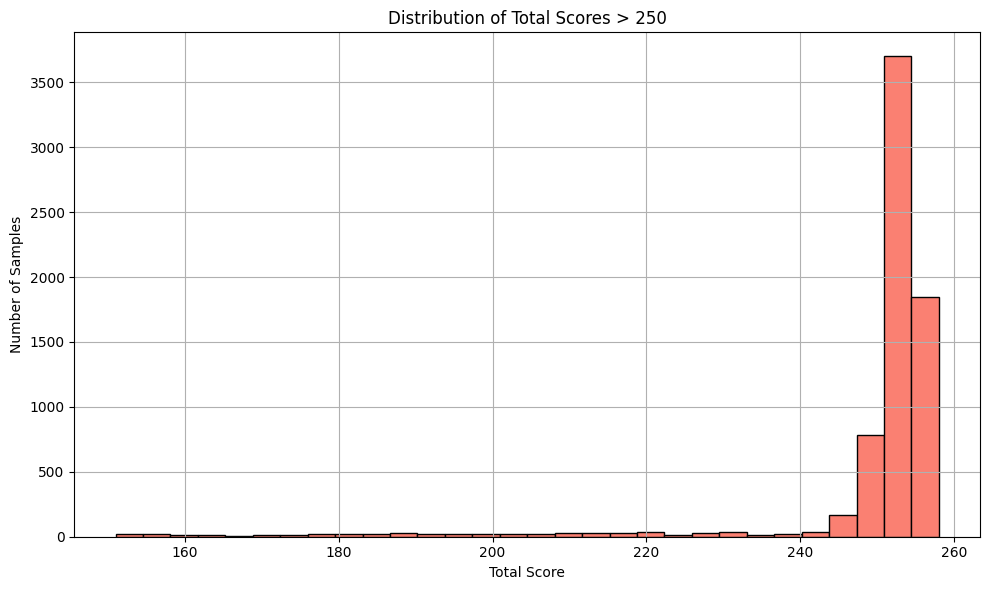

In [101]:
import matplotlib.pyplot as plt

# Filter to include only rows with total_score > 250
high_scores = scores_df[scores_df["total_score"] > 150]

plt.figure(figsize=(10, 6))
plt.hist(high_scores["total_score"], bins=30, edgecolor='black', color='salmon')
plt.title("Distribution of Total Scores > 250")
plt.xlabel("Total Score")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.tight_layout()
plt.show()


In [102]:
ids_255 = scores_df[scores_df["total_score"] > 127]["id"]
print("IDs with total score = 253:")
print(ids_255.tolist())

IDs with total score = 253:
['mp-1025922', 'mp-1025988', 'mp-1026034', 'mp-1026980', 'mp-1027335', 'mp-1027569', 'mp-1027645', 'mp-1027647', 'mp-1028558', 'mp-1029246', 'mp-1040929', 'mp-1040938', 'mp-1040942', 'mp-1040943', 'mp-1040983', 'mp-1040986', 'mp-1041000', 'mp-1041004', 'mp-1041012', 'mp-1041014', 'mp-1041039', 'mp-1041063', 'mp-1041142', 'mp-1041154', 'mp-1041156', 'mp-1041171', 'mp-1041298', 'mp-1041366', 'mp-1041378', 'mp-1044582', 'mp-1044601', 'mp-1044622', 'mp-1044625', 'mp-1044628', 'mp-1044635', 'mp-1044645', 'mp-1044647', 'mp-1044657', 'mp-1044668', 'mp-1044814', 'mp-1044835', 'mp-1044865', 'mp-1044880', 'mp-1044895', 'mp-1044896', 'mp-1044907', 'mp-1044913', 'mp-1044919', 'mp-1044926', 'mp-1044933', 'mp-1044943', 'mp-1048859', 'mp-1048867', 'mp-1048893', 'mp-1048964', 'mp-1049224', 'mp-1049284', 'mp-1049295', 'mp-1096788', 'mp-1096814', 'mp-1096942', 'mp-1100814', 'mp-1100834', 'mp-1100868', 'mp-1101422', 'mp-1103047', 'mp-1103054', 'mp-1103879', 'mp-1173103', 'mp-1

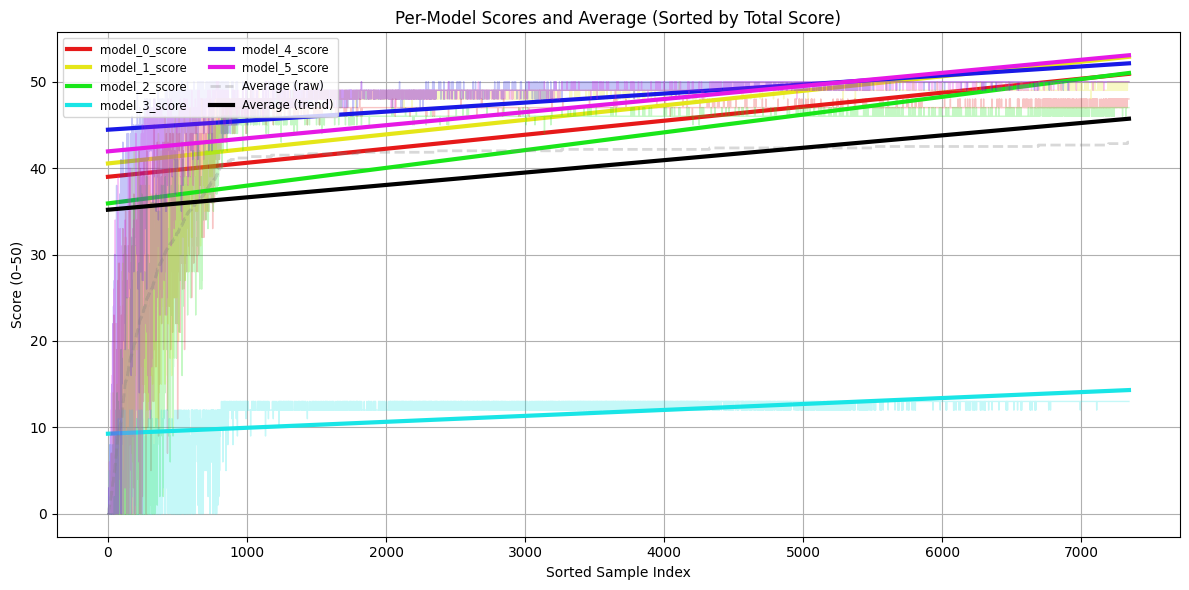

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import colorsys

# Sort the DataFrame
sorted_scores_df = scores_df.sort_values(by="total_score", ascending=True).reset_index(drop=True)

plt.figure(figsize=(12, 6))

x = sorted_scores_df.index.values
model_cols = sorted_scores_df.columns[1:-1]  # all model columns, excluding 'id' and 'total_score'
num_models = len(model_cols)

# Generate distinct colors using HSV
def get_distinct_colors(n):
    colors = []
    for i in range(n):
        hue = i / n
        rgb = colorsys.hls_to_rgb(hue, 0.5, 0.8)
        colors.append(rgb)
    return colors

colors = get_distinct_colors(num_models)

# Plot each model's line and trend
for i, col in enumerate(model_cols):
    y = sorted_scores_df[col].values
    color = colors[i]

    plt.plot(x, y, color=color, alpha=0.25, linewidth=1)  # Raw data
    coeffs = np.polyfit(x, y, deg=1)
    trend = np.poly1d(coeffs)
    plt.plot(x, trend(x), color=color, linewidth=3, label=col)  # Trend line

# Plot average score across all models
avg_scores = sorted_scores_df[model_cols].mean(axis=1)
avg_coeffs = np.polyfit(x, avg_scores, deg=1)
avg_trend = np.poly1d(avg_coeffs)

# Plot raw average (optional) and trend line
plt.plot(x, avg_scores, color='gray', alpha=0.3, linewidth=2, linestyle='--', label='Average (raw)')
plt.plot(x, avg_trend(x), color='black', linewidth=3, linestyle='-', label='Average (trend)')

plt.title("Per-Model Scores and Average (Sorted by Total Score)")
plt.xlabel("Sorted Sample Index")
plt.ylabel("Score (0–50)")
plt.grid(True)
plt.legend(loc='upper left', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()


In [104]:
import torch
import torch.nn as nn

class DeeperNLCModel(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        dropout_rate = 0.5

        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),

            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),

            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.ReLU(),

            nn.Linear(8, 4),
            nn.BatchNorm1d(4),
            nn.ReLU(),

            nn.Linear(4, 1)  # Final output layer
        )

    def forward(self, x):
        return self.model(x)


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, input, target):
        bce_loss = self.bce(input, target)
        pt = torch.exp(-bce_loss)
        focal = self.alpha * (1 - pt) ** self.gamma * bce_loss
        return focal.mean()


In [105]:
import torch
import glob
import numpy as np
import pandas as pd

# --- Configuration ---
model_paths = glob.glob("models/torch_class_f1.*.pt")  # all matching torch models
thresholds = np.round(np.arange(0.50, 1.00, 0.01), 2)  # thresholds to test

# --- Load input (NumPy array) and convert to tensor ---
input_tensor = torch.tensor(X, dtype=torch.float32)

# --- Store score arrays per model ---
model_scores = []

for path in model_paths:
    # Load model
    model = torch.load(path, weights_only=False)
    model.eval()

    # Run inference
    with torch.no_grad():
        outputs = model(input_tensor)

    # If output is logits, convert to probabilities
    if outputs.shape[1] == 1:
        probs = torch.sigmoid(outputs).squeeze().numpy()  # shape: (n_samples,)
    else:
        probs = torch.softmax(outputs, dim=1)[:, 1].numpy()  # shape: (n_samples,)

    # Apply thresholds to compute scores
    score = np.zeros_like(probs, dtype=int)
    for threshold in thresholds:
        score += (probs >= threshold).astype(int)

    model_scores.append(score)
    print(f"{path}: Done scoring")

# --- Build DataFrame: rows = samples, columns = models ---
scores_df = pd.DataFrame(model_scores).T
scores_df.columns = [f"model_{i}_score" for i in range(len(model_scores))]

# Add sample IDs
scores_df.insert(0, "id", ids.values)

# Add total score per sample across all models
scores_df["total_score"] = scores_df.iloc[:, 1:].sum(axis=1)

# --- Save result ---
scores_df.to_csv("torch_threshold_scores.csv", index=False)
print("Saved torch_threshold_scores.csv")


models\torch_class_f1.7.0.pt: Done scoring
models\torch_class_f1.7.1.pt: Done scoring
models\torch_class_f1.7.2.pt: Done scoring
Saved torch_threshold_scores.csv


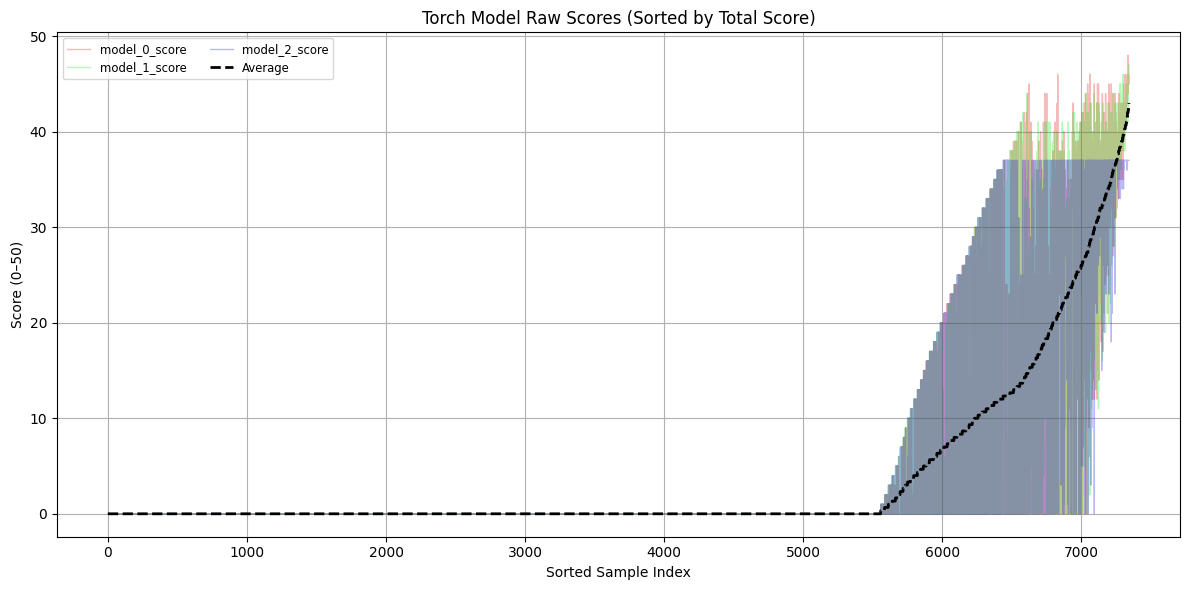

In [106]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import colorsys

# --- Load the threshold scores ---
scores_df = pd.read_csv("torch_threshold_scores.csv")

# --- Sort by total_score ---
sorted_scores_df = scores_df.sort_values(by="total_score", ascending=True).reset_index(drop=True)

plt.figure(figsize=(12, 6))

x = sorted_scores_df.index.values
model_cols = sorted_scores_df.columns[1:-1]  # Exclude 'id' and 'total_score'
num_models = len(model_cols)

# --- Generate distinct colors ---
def get_distinct_colors(n):
    colors = []
    for i in range(n):
        hue = i / n
        rgb = colorsys.hls_to_rgb(hue, 0.5, 0.8)
        colors.append(rgb)
    return colors

colors = get_distinct_colors(num_models)

# --- Plot each model's raw score line ---
for i, col in enumerate(model_cols):
    y = sorted_scores_df[col].values
    color = colors[i]
    plt.plot(x, y, color=color, alpha=0.3, linewidth=1, label=col)

# --- Plot raw average score line ---
avg_scores = sorted_scores_df[model_cols].mean(axis=1)
plt.plot(x, avg_scores, color='black', linewidth=2, linestyle='--', label='Average')

# --- Plot formatting ---
plt.title("Torch Model Raw Scores (Sorted by Total Score)")
plt.xlabel("Sorted Sample Index")
plt.ylabel("Score (0–50)")
plt.grid(True)
plt.legend(loc='upper left', fontsize='small', ncol=2)
plt.tight_layout()
plt.show()


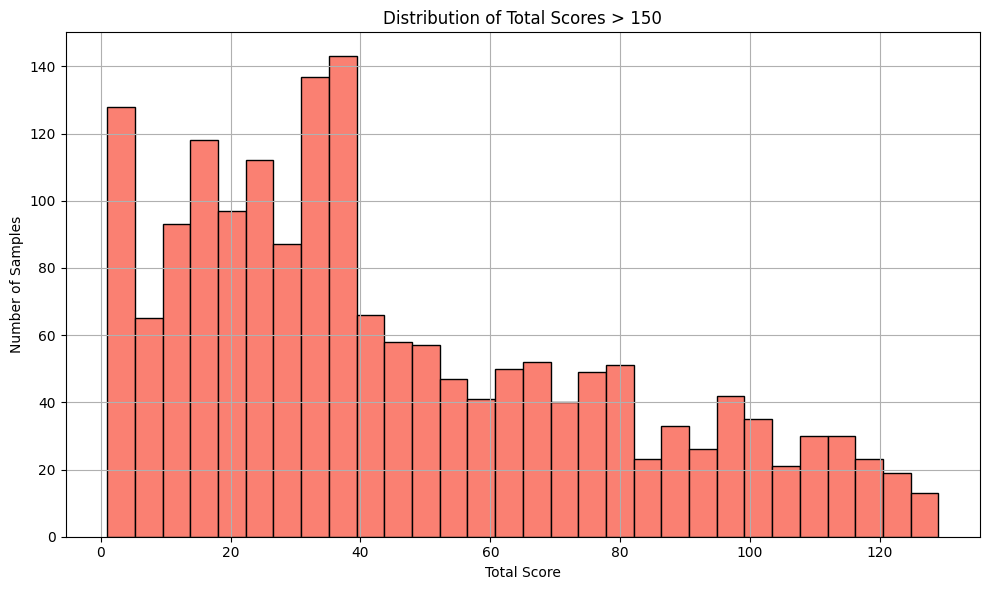

In [107]:
import matplotlib.pyplot as plt
import pandas as pd

# --- Load the threshold scores ---
scores_df = pd.read_csv("torch_threshold_scores.csv")

# --- Filter for high-scoring samples ---
high_scores = scores_df[scores_df["total_score"] > 0]

# --- Plot histogram ---
plt.figure(figsize=(10, 6))
plt.hist(high_scores["total_score"], bins=30, edgecolor='black', color='salmon')
plt.title("Distribution of Total Scores > 150")
plt.xlabel("Total Score")
plt.ylabel("Number of Samples")
plt.grid(True)
plt.tight_layout()
plt.show()


In [108]:
scores_df = pd.read_csv("torch_threshold_scores.csv")

# Sort by total_score descending and select top 10
top10 = scores_df.sort_values(by="total_score", ascending=False).head(20)

# Print the results
print("Top 10 Highest Scoring Materials:")
print(top10[["id", "total_score"]])

Top 10 Highest Scoring Materials:
              id  total_score
2480     mp-4649          129
3239   mp-867824          128
2908   mp-753556          128
2919   mp-753884          127
3195   mp-777801          127
2892   mp-752898          127
2841   mp-725152          126
1621  mp-2012385          126
2843   mp-725977          126
6121  mp-1179638          126
6149  mp-1194215          126
2846   mp-726394          125
5392  mp-1223898          125
3216   mp-804970          124
2813   mp-695952          124
2816   mp-697730          124
2840   mp-724868          123
2593   mp-556202          123
2023  mp-1365085          123
3013   mp-757119          123


In [109]:
xgb_scores_df = pd.read_csv("threshold_scores.csv")

# Sort by total_score in descending order and take top 10
top10_xgb = xgb_scores_df.sort_values(by="total_score", ascending=False).head(20)

# Print only ID and total score
print("Top 10 Highest Scoring Materials (XGBoost):")
print(top10_xgb[["id", "total_score"]])

Top 10 Highest Scoring Materials (XGBoost):
              id  total_score
3676    mp-18913          258
2129  mp-1079364          258
1666    mp-28873          258
2177  mp-1205774          258
1657    mp-27193          258
2843   mp-725977          258
4433     mp-3481          258
5888  mp-1206815          258
1794     mp-7684          258
1716   mp-550506          258
1720   mp-552729          258
7142  mp-1245608          257
6396   mp-756016          257
7178  mp-1246803          257
5626  mp-1078772          257
3336  mp-1221512          257
5592    mp-10379          257
3376  mp-1222342          257
4331  mp-1225870          257
2071  mp-1018779          257
